In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..'))  # Adds the parent directory of 'script' to Python path

from script.utils.model_utils import *
from script.utils.data_utils import *
from script.utils.eval_utils import *
from script.utils.prompt_utils import *

/Users/joyqiu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joyqiu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize model
model_name = "meta-llama/Llama-3.1-8B-Instruct"
model, tokenizer = setup_model(model_name)

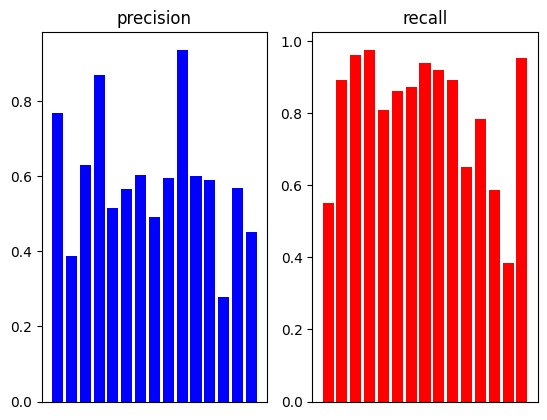

In [3]:
# Load and process data
label_df, label_df_human, fea_df = load_and_process_labels(
    "../../data/post1080.csv",
    "llama",
    "../../data/fea.csv"
)
label_df2 = label_df.copy()
label_df2 = label_df2.drop(columns=['raw_text'])
label_df3 = label_df.copy()
label_df3 = label_df3.drop(columns=['raw_text'])

pft = check_precision_recall(label_df, label_df_human, fea_df)


In [ ]:
from tqdm import tqdm

count = 0
for sm_id in tqdm(label_df.index, desc="Processing each post") :# '1068zm3' is a good test sm_id
    count += 1
    # get the raw text of this sm_id
    raw_text = label_df.loc[sm_id, 'raw_text']
    
    # ----- 1. Detect potential false negatives -----
    # collect all positive labels for all features in fea_df.fea for this sm_id 
    sm_pos = [col for col in label_df.columns if col != 'raw_text' and label_df.loc[sm_id, col] == 1]
    # collect all negative labels for all features in fea_df.fea for this sm_id 
    sm_neg = [col for col in label_df.columns if col != 'raw_text' and label_df.loc[sm_id, col] == 0]
    # new postives
    new_pos = []
    if len(sm_pos) >= 1:
        sm_posneg_matrix = get_pos_neg_matrix(sm_pos, sm_neg, raw_text, tokenizer, model)
        sm_posneg_matrix = sm_posneg_matrix.transpose()
        sm_posneg_matrix['yes_ratio'] = sm_posneg_matrix.apply(lambda row: 1-row.value_counts().get('no.', 0) / len(row), axis=1)
        new_pos += sm_posneg_matrix[sm_posneg_matrix['yes_ratio'] > 0.5].index.tolist()
    if len(new_pos)>0:
        # store the result in 2nd shot label_df: label_df2
        for col in new_pos:
            label_df2.loc[sm_id, col] = 1
            label_df3.loc[sm_id, col] = 1
    pft_new = check_precision_recall(label_df2, label_df_human, fea_df, plot=False)
    if count % 10 == 0:# plot for every 10 sm_id
        plot_precision_recall_diff(pft_new, pft)
        pft = pft_new
        
    # ----- 2. Detect potential false positives -----
    # collect all positive labels for all features in fea_df.fea for this sm_id 
    sm_pos = [col for col in label_df2.columns if col != 'raw_text' and label_df2.loc[sm_id, col] == 1]
    # new negatives
    new_neg = []
    if len(sm_pos) > 1:
        sm_pospos_matrix = get_pos_pos_matrix(sm_pos, raw_text, tokenizer, model)
        sm_pospos_matrix = sm_pospos_matrix.transpose()
        sm_pospos_matrix['no_ratio'] = sm_pospos_matrix.apply(lambda row: row.value_counts().get('no.', 0) / len(row), axis=1)
        new_neg += sm_pospos_matrix[sm_pospos_matrix['no_ratio'] > 0.5].index.tolist()
    if len(new_neg)>0:
        # store the result in 3rd shot label_df: label_df3
        for col in new_neg:
            label_df3.loc[sm_id, col] = 0
    pft_new = check_precision_recall(label_df3, label_df_human, fea_df, plot=False)
    if count % 10 == 0:# plot for every 10 sm_id
        plot_precision_recall_diff(pft_new, pft)
        pft = pft_new
    